In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [31]:
# --- Helper Function for Feature Engineering ---
def create_features(df):
    """Creates time-series features from a stock dataframe."""
    # Simple Moving Averages (SMA)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Exponential Moving Average (EMA)
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.ewm(com=13, adjust=False).mean()
    avg_loss = loss.ewm(com=13, adjust=False).mean()
    epsilon = 1e-10
    rs = avg_gain / (avg_loss + epsilon)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    sma_20 = df['Close'].rolling(window=20).mean()
    std_20 = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = sma_20 + (2 * std_20)
    df['BB_Lower'] = sma_20 - (2 * std_20)

    # --- Convert features to percentage difference from Close price ---
    df['SMA_20_pct'] = (df['SMA_20'] - df['Close']) / df['Close']
    df['SMA_50_pct'] = (df['SMA_50'] - df['Close']) / df['Close']
    df['EMA_20_pct'] = (df['EMA_20'] - df['Close']) / df['Close']
    df['BB_Upper_pct'] = (df['BB_Upper'] - df['Close']) / df['Close']
    df['BB_Lower_pct'] = (df['BB_Lower'] - df['Close']) / df['Close']

    # Price Range as a percentage of Close
    df['Price_Range_pct'] = (df['High'] - df['Low']) / df['Close']

    # --- Target Variable: Next Day's Percentage Change ---
    df['Target_Pct_Change'] = df['Close'].pct_change().shift(-1)

    # Drop rows with NaN values
    df.dropna(inplace=True)

    return df


In [36]:

# # --- 1. Data Collection ---
# # Download historical stock data for Apple (AAPL)
# try:
#     aapl_df = yf.download('AAPL', start='2010-01-01', end='2025-06-01')
#     if aapl_df.empty:
#         raise ValueError("No data downloaded. Check the ticker symbol or date range.")
#     print("Successfully downloaded AAPL stock data.")
# except Exception as e:
#     print(f"Error downloading data: {e}")
#     # Fallback to dummy data if download fails
#     date_rng = pd.date_range(start='2010-01-01', end='2025-06-01', freq='B')
#     aapl_df = pd.DataFrame(date_rng, columns=['Date'])
#     aapl_df['Open'] = np.random.uniform(100, 500, size=(len(date_rng)))
#     aapl_df['High'] = aapl_df['Open'] + np.random.uniform(0, 10)
#     aapl_df['Low'] = aapl_df['Open'] - np.random.uniform(0, 10)
#     aapl_df['Close'] = (aapl_df['High'] + aapl_df['Low']) / 2
#     aapl_df['Volume'] = np.random.randint(1000000, 50000000, size=(len(date_rng)))
#     aapl_df.set_index('Date', inplace=True)
#     print("Using dummy data for demonstration.")
# --- 1. Data Collection ---
try:
    aapl_df_raw = yf.download('AAPL', start='2010-01-01', end='2025-06-01')
    if aapl_df_raw.empty:
        raise ValueError("No data downloaded for AAPL.")
    print("Successfully downloaded AAPL stock data.")
except Exception as e:
    print(f"Error downloading data: {e}")

# Flatten and clean data
if isinstance(aapl_df_raw.columns, pd.MultiIndex):
    aapl_df_raw.columns = aapl_df_raw.columns.get_level_values(0)
aapl_df_raw.ffill(inplace=True)

/tmp/ipython-input-36-4038595848.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_df_raw = yf.download('AAPL', start='2010-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

Successfully downloaded AAPL stock data.


In [37]:
aapl_df_raw

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479381,6.409054,6.449628,601904800
2010-01-06,6.340533,6.468564,6.333921,6.443018,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370885,6.371486,6.283127,6.320394,447610800
...,...,...,...,...,...
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500
2025-05-28,200.419998,202.729996,199.899994,200.589996,45339700


In [38]:
# --- 2. Feature Engineering ---
aapl_df = create_features(aapl_df_raw.copy())

print("\nData after Feature Engineering (showing percentage-based features):")
print(aapl_df[['Close', 'SMA_20_pct', 'RSI', 'Price_Range_pct', 'Target_Pct_Change']].head())



Data after Feature Engineering (showing percentage-based features):
Price          Close  SMA_20_pct        RSI  Price_Range_pct  \
Date                                                           
2010-03-16  6.745662   -0.056344  70.480253         0.011005   
2010-03-17  6.735744   -0.050143  69.690972         0.014189   
2010-03-18  6.751673   -0.047550  70.266866         0.010639   
2010-03-19  6.679543   -0.032634  64.308463         0.018043   
2010-03-22  6.754679   -0.037982  67.408719         0.026029   

Price       Target_Pct_Change  
Date                           
2010-03-16          -0.001470  
2010-03-17           0.002365  
2010-03-18          -0.010683  
2010-03-19           0.011249  
2010-03-22           0.016062  


In [39]:
aapl_df.isna().sum()

,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0
SMA_20,0
SMA_50,0
EMA_20,0
RSI,0


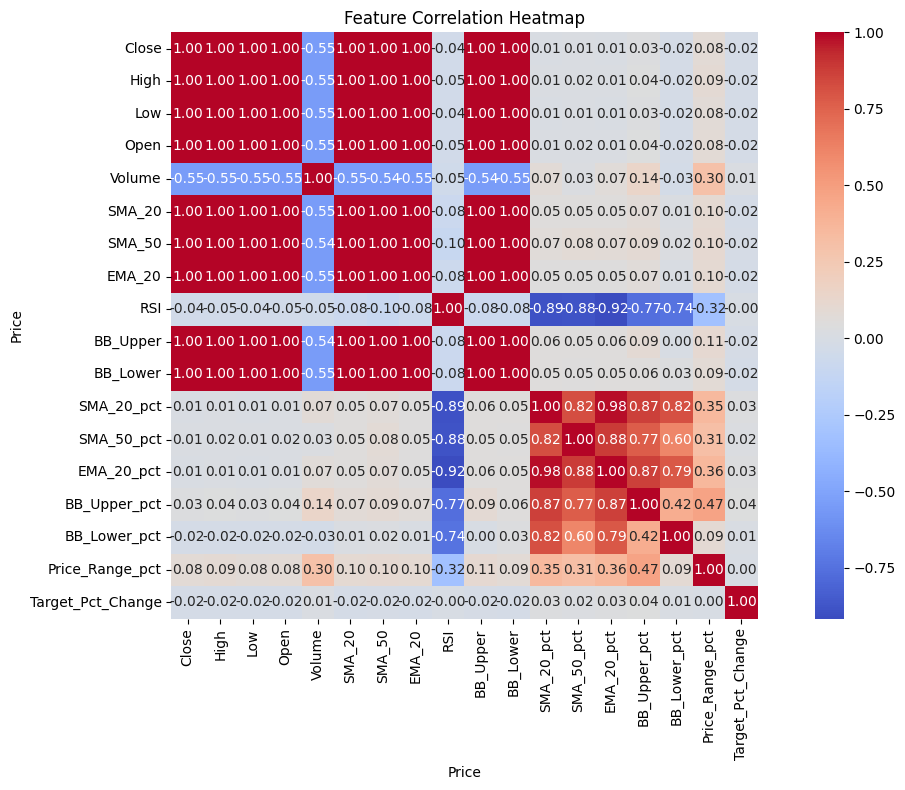

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = aapl_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [40]:
aapl_df

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_20,RSI,BB_Upper,BB_Lower,SMA_20_pct,SMA_50_pct,EMA_20_pct,BB_Upper_pct,BB_Lower_pct,Price_Range_pct,Target_Pct_Change
Date,,,,,,,,,,,,,,,,,,
2010-03-16,6.745662,6.761591,6.687357,6.737548,446908000,6.365582,6.219936,6.455709,70.480253,6.985506,5.745658,-0.056344,-0.077935,-0.042984,0.035555,-0.148244,0.011005,-0.001470
2010-03-17,6.735744,6.805769,6.710198,6.759186,450956800,6.397995,6.226013,6.482379,69.690972,7.024450,5.771540,-0.050143,-0.075675,-0.037615,0.042862,-0.143147,0.014189,0.002365
2010-03-18,6.751673,6.762192,6.690362,6.735143,342109600,6.430634,6.232186,6.508026,70.266866,7.059491,5.801777,-0.047550,-0.076942,-0.036087,0.045591,-0.140690,0.010639,-0.010683
2010-03-19,6.679543,6.769406,6.648888,6.755881,559445600,6.461560,6.238966,6.524361,64.308463,7.074518,5.848602,-0.032634,-0.065959,-0.023233,0.059132,-0.124401,0.018043,0.011249
2010-03-22,6.754679,6.792247,6.616430,6.626048,456419600,6.498121,6.247484,6.546296,67.408719,7.087842,5.908400,-0.037982,-0.075088,-0.030850,0.049323,-0.125288,0.026029,0.016062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,201.360001,202.750000,199.699997,200.710007,46742400,206.318570,206.546597,205.714718,44.397639,218.460426,194.176714,0.024625,0.025758,0.021627,0.084925,-0.035674,0.015147,-0.030244
2025-05-23,195.270004,197.699997,193.460007,193.669998,78432900,205.631774,206.263889,204.719983,38.828188,218.655496,192.608052,0.053064,0.056301,0.048394,0.119760,-0.013632,0.021713,0.025298
2025-05-27,200.210007,200.740005,197.429993,198.300003,56288500,205.149035,206.003881,204.290462,44.869601,218.227734,192.070336,0.024669,0.028939,0.020381,0.089994,-0.040656,0.016533,0.001049


In [42]:
# --- 3. Data Preprocessing ---
features = ['SMA_20_pct', 'SMA_50_pct', 'EMA_20_pct', 'RSI', 'BB_Upper_pct', 'BB_Lower_pct', 'Price_Range_pct']
target = 'Target_Pct_Change'
num_features = len(features)

# Combine features and target for scaling
data_to_scale = aapl_df[features + [target]].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_scale)


In [43]:
# --- 4. Create Training Data ---
look_back = 60
X, y = [], []

for i in range(look_back, len(scaled_data)):
    # X contains the last 'look_back' days of all features
    X.append(scaled_data[i-look_back:i, :-1]) # All columns except the last (target)
    # y contains the scaled target percentage change
    y.append(scaled_data[i, -1]) # The last column

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], num_features))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# Keep track of the actual close prices for the test set to calculate predicted prices later
actual_close_prices_test = aapl_df['Close'].iloc[-len(X_test):].values

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



X_train shape: (3012, 60, 7)
y_train shape: (3012,)


In [44]:
# --- 5. Build the LSTM Model ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,051 (203.32 KB)

 Trainable params: 52,051 (203.32 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# --- 6. Train the Model ---
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - loss: 0.0276 - val_loss: 0.0042
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 0.0056 - val_loss: 0.0043
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step -

In [46]:
# --- 7. Evaluate the Model and Make Predictions ---
# Predict the scaled percentage change
predictions_scaled = model.predict(X_test)

# To inverse transform, we need a dummy array of the correct shape
dummy_array = np.zeros((len(predictions_scaled), num_features + 1))
dummy_array[:, -1] = predictions_scaled.flatten()
predicted_pct_change = scaler.inverse_transform(dummy_array)[:, -1]

# Calculate the predicted stock prices
predicted_prices = []
# The first prediction is based on the day before the test set starts
last_actual_price = aapl_df['Close'].iloc[-len(X_test)-1]

for pct_change in predicted_pct_change:
    predicted_price = last_actual_price * (1 + pct_change)
    predicted_prices.append(predicted_price)
    # For the next prediction, we use the actual price of the current day
    # This prevents compounding errors in the visualization and RMSE calculation.
    # We find the index to get the correct actual price.
    current_index = len(aapl_df) - len(X_test) + len(predicted_prices) - 1
    last_actual_price = aapl_df['Close'].iloc[current_index]

predicted_prices = np.array(predicted_prices)

# Calculate RMSE on the prices
rmse = np.sqrt(np.mean(((predicted_prices - actual_close_prices_test) ** 2)))
print(f"\nRoot Mean Squared Error (RMSE) on AAPL test data: ${rmse:.2f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Root Mean Squared Error (RMSE) on AAPL test data: $3.28


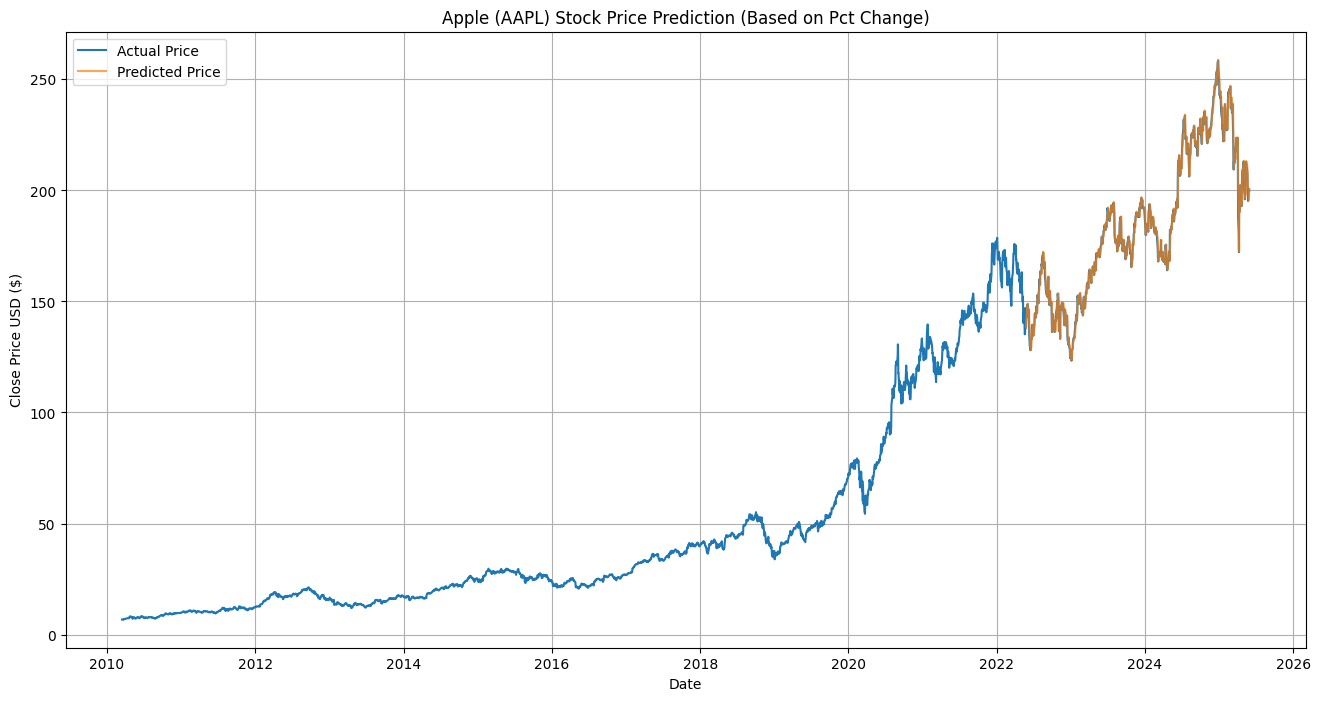

In [47]:
# --- 8. Visualize the Results ---
plot_df = aapl_df.iloc[-len(X_test):].copy()
plot_df['Predictions'] = predicted_prices

plt.figure(figsize=(16, 8))
plt.title('Apple (AAPL) Stock Price Prediction (Based on Pct Change)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(aapl_df['Close'], label='Actual Price')
plt.plot(plot_df.index, plot_df['Predictions'], label='Predicted Price', alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# --- 9. Predict Future Stock Price for AAPL ---
print("\n--- Predicting next day's price for AAPL ---")
# We need the last 'look_back' days of FEATURES from the scaled data.
# The shape should be (60, num_features), which is (60, 7).
# We select all columns except the last one (the target).
last_60_days_features = scaled_data[-look_back:, :-1]

# Reshape this to the format the model expects: (1, timesteps, features)
input_for_prediction = np.reshape(last_60_days_features, (1, look_back, num_features))

# Predict the scaled percentage change
next_day_scaled_pct_change = model.predict(input_for_prediction)

# Inverse transform the prediction
dummy_array_future = np.zeros((1, num_features + 1))
dummy_array_future[0, -1] = next_day_scaled_pct_change[0, 0]
next_day_pct_change = scaler.inverse_transform(dummy_array_future)[0, -1]

# Calculate the predicted price
last_actual_price = aapl_df['Close'].iloc[-1]
predicted_next_day_price = last_actual_price * (1 + next_day_pct_change)

print(f"\nLast actual closing price for AAPL: ${last_actual_price:.2f}")
print(f"Predicted percentage change for next day: {next_day_pct_change:.4%}")
print(f"Predicted closing price for the next trading day: ${predicted_next_day_price:.2f}")




--- Predicting next day's price for AAPL ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Last actual closing price for AAPL: $199.95
Predicted percentage change for next day: 0.1187%
Predicted closing price for the next trading day: $200.19



--- Testing model on a different stock (MSFT) without retraining ---


/tmp/ipython-input-53-310900357.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_df_raw = yf.download(new_ticker, start='2010-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

  1/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step

Root Mean Squared Error (RMSE) on NVDA data: $1.29


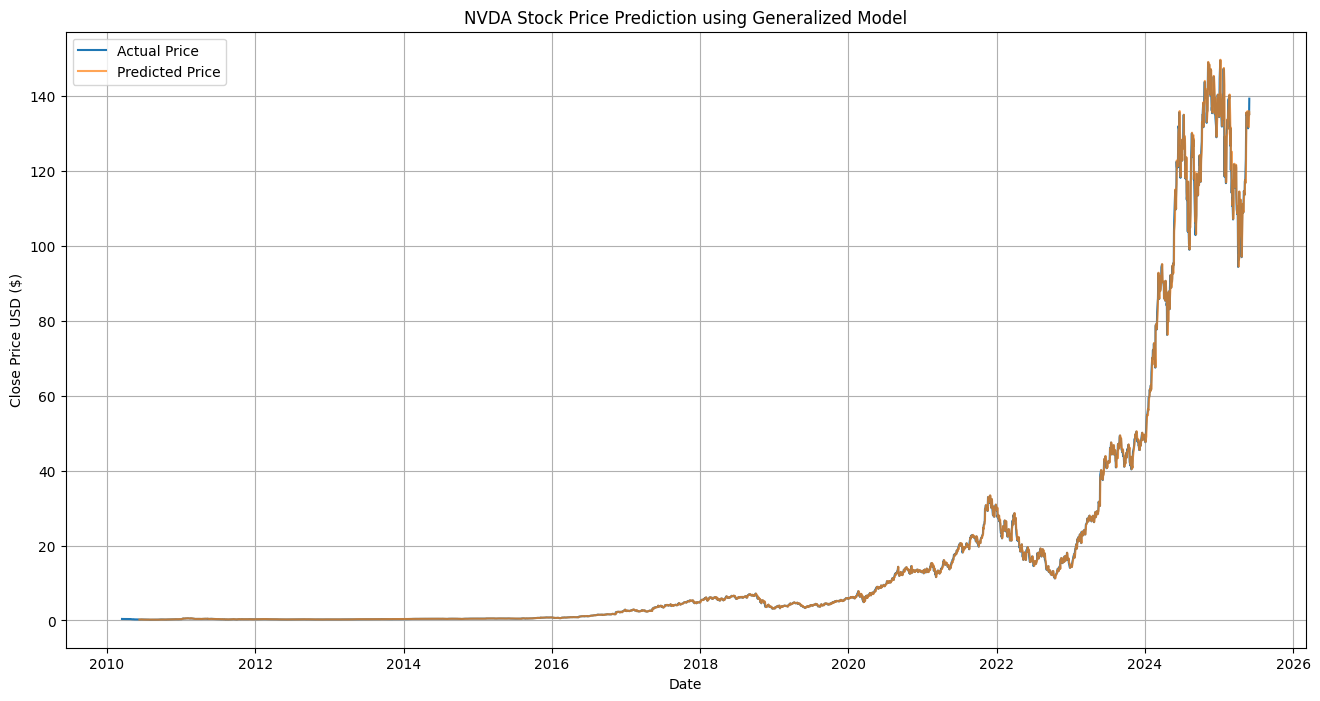

In [53]:
# --- 9. Test Model on New, Unseen Data (e.g., MSFT) ---
print("\n--- Testing model on a different stock (MSFT) without retraining ---")
try:
    # 1. Download and process new data
    new_ticker = 'NVDA'
    new_df_raw = yf.download(new_ticker, start='2010-01-01', end='2025-06-01')
    if isinstance(new_df_raw.columns, pd.MultiIndex):
        new_df_raw.columns = new_df_raw.columns.get_level_values(0)
    new_df_raw.ffill(inplace=True)
    new_df = create_features(new_df_raw.copy())

    # 2. Preprocess using the ORIGINAL scaler
    new_data_to_scale = new_df[features + [target]].values
    new_scaled_data = scaler.transform(new_data_to_scale)

    # 3. Create input sequences
    X_new, y_new_actual_prices = [], []
    for i in range(look_back, len(new_scaled_data)):
        X_new.append(new_scaled_data[i-look_back:i, :-1])
        y_new_actual_prices.append(new_df['Close'].iloc[i])

    X_new = np.array(X_new)
    y_new_actual_prices = np.array(y_new_actual_prices)

    # 4. Make predictions
    new_predictions_scaled = model.predict(X_new)

    # 5. Inverse transform and calculate predicted prices
    dummy_array_new = np.zeros((len(new_predictions_scaled), num_features + 1))
    dummy_array_new[:, -1] = new_predictions_scaled.flatten()
    new_predicted_pct_change = scaler.inverse_transform(dummy_array_new)[:, -1]

    new_predicted_prices = []
    last_actual_price_new = new_df['Close'].iloc[look_back-1]
    for i in range(len(new_predicted_pct_change)):
        price = new_df['Close'].iloc[look_back + i -1] * (1 + new_predicted_pct_change[i])
        new_predicted_prices.append(price)

    new_predicted_prices = np.array(new_predicted_prices)

    # 6. Visualize and evaluate
    new_rmse = np.sqrt(np.mean(((new_predicted_prices - y_new_actual_prices) ** 2)))
    print(f"\nRoot Mean Squared Error (RMSE) on {new_ticker} data: ${new_rmse:.2f}")

    plt.figure(figsize=(16, 8))
    plt.title(f'{new_ticker} Stock Price Prediction using Generalized Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(new_df.index, new_df['Close'], label='Actual Price')
    plt.plot(new_df.index[look_back:], new_predicted_prices, label='Predicted Price', alpha=0.7)
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred while testing on new data: {e}")
